# Final Project - Transfer Learning Tutorial

## *Team 8: Pinkies*
Yuan Feng [yf115]\
Sebastián Soriano Pérez [ss1072]\
Vishaal Venkatesh [vv58]\
Abhiraj Vinnakota [agv9]\
Roderick Whang [rjw34]

## 1. Jupyter Notebook Setup

Importing all necessary packages and additional setups for this notebook to run properly.

In [1]:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'

In [2]:
'''
Import packages
'''
# Based on code from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import (average_precision_score, roc_curve, roc_auc_score, precision_recall_curve, 
                             confusion_matrix)
import time
import os
import copy
import warnings

In [3]:
'''
Set directory parameters and additional setups
'''
# Set the directories for the image dataset
# (The folder structure should include /train and /val folders with /[class1] and /[class2] images inside each)
data_dir = '../Data/hymenoptera_data'

# Additional setups
warnings.filterwarnings('ignore')
plt.ion()   # interactive mode
device  = torch.device("cpu")
palette = ['darkcyan', 'turquoise', 'deeppink', 'hotpink']

## 2. Function Definition

Definition of every function needed to load the datasets, preprocess the data and extract features, define the classigication models, test the cross validated performance of the models, and plot the performance metrics.

In [4]:
def load_data(data_dir):
    '''
    Function to load the training and validation data from the input directory
    '''
    data_transforms = {
        'train': 
        transforms.Compose(
            [transforms.RandomResizedCrop(224),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ),
        'val':
        transforms.Compose(
            [transforms.Resize(256),
             transforms.CenterCrop(224),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        ),
    }
    
    sets = ['train', 'val']
    
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_dir, x), data_transforms[x]
        ) for x in sets
    }
    
    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x], batch_size=4, shuffle=True, num_workers=0,
        ) for x in sets
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in sets}
    class_names   = image_datasets['train'].classes
    
    return image_datasets, dataloaders, dataset_sizes, class_names

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    '''
    Function to train the model input with the specified parameters and number of epochs.
    
    Returns the best model found in any given epoch, the losses found on every epoch (for train and val)
    '''
    since          = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc       = 0.0
    
    train_losses = []
    val_losses   = []

    for epoch in range(num_epochs):
        print('epoch {}:'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss     = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss     = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            # deep copy the model if it has the best val accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('{} - loss: {:.4f}; acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        print('-' * 10)
        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses

In [6]:
def get_scores(model, dataloaders, train=False):
    '''
    Returns model's prediction scores and actual labels.
    '''
    model.eval()
    
    dataset = 'train' if train else 'val'
    y       = []
    scores  = []
    
    for i, (inputs, labels) in enumerate(dataloaders[dataset]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs  = model(inputs)
        _, preds = torch.max(outputs, 1)

        sm            = torch.nn.Softmax()
        probabilities = sm(outputs) 

        for j in range(len(labels.tolist())):
            y.append(labels.tolist()[j])
            scores.append(probabilities.tolist()[j][1])
    
    return y, scores

In [24]:
def plot_roc(labels, prediction_scores, legend, color):
    '''
    Function to plot ROC curve
    '''
    fpr, tpr, _   = roc_curve(labels, prediction_scores, pos_label = 1)
    auc           = roc_auc_score(labels, prediction_scores)
    legend_string = legend + ' ($AUC = {:0.3f}$)'.format(auc)  
    plt.plot(fpr, tpr, label = legend_string, color = color)

In [25]:
def plot_prc(labels, prediction_scores, legend, color):
    '''
    Function to plot PRC curve
    '''
    precision, recall, thresholds = precision_recall_curve(labels, prediction_scores)
    average_precision = average_precision_score(labels, prediction_scores)
    legend_string = legend + ' ($AP = {:0.3f}$)'.format(average_precision)  
    plt.plot(recall, precision, label = legend_string, color = color)

## 3. Model Fitting and Performance on Validation Set

Performance on the validation sets for both models used.

In [9]:
'''
Loading data
'''
image_datasets, dataloaders, dataset_sizes, class_names = load_data(data_dir)

In [10]:
'''
Model 1: CNN Trained from Scratch
'''
# Create model with pretrained=False, weights are initialized by the resnet18 class
model1 = models.resnet18(pretrained=False)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
num_ftrs1 = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs1, 2)

model1     = model1.to(device)
criterion1 = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)

# Model training
model1, train_losses1, val_losses1 = train_model(
    model1, criterion1, optimizer1, exp_lr_scheduler1, num_epochs=30
)

# Get model prediction scores on validation set
y1, scores1 = get_scores(model1, dataloaders)

epoch 0:
train - loss: 0.7155; acc: 0.5738
val - loss: 0.6382; acc: 0.6144
----------

epoch 1:
train - loss: 0.7933; acc: 0.5697
val - loss: 0.7444; acc: 0.5490
----------

epoch 2:
train - loss: 0.9137; acc: 0.5615
val - loss: 0.8230; acc: 0.6405
----------

epoch 3:
train - loss: 0.6879; acc: 0.5943
val - loss: 0.9874; acc: 0.5948
----------

epoch 4:
train - loss: 0.7580; acc: 0.5779
val - loss: 0.7287; acc: 0.5752
----------

epoch 5:
train - loss: 0.6326; acc: 0.6516
val - loss: 0.6917; acc: 0.6797
----------

epoch 6:
train - loss: 0.7409; acc: 0.6148
val - loss: 0.6010; acc: 0.6797
----------

epoch 7:
train - loss: 0.6325; acc: 0.6557
val - loss: 0.6810; acc: 0.7320
----------

epoch 8:
train - loss: 0.5660; acc: 0.7213
val - loss: 0.6497; acc: 0.6993
----------

epoch 9:
train - loss: 0.5656; acc: 0.7377
val - loss: 0.7299; acc: 0.6928
----------

epoch 10:
train - loss: 0.5687; acc: 0.7049
val - loss: 0.6293; acc: 0.7190
----------

epoch 11:
train - loss: 0.6281; acc: 0.623

In [11]:
'''
Model 2: CNN Trained with Transfer Learning
'''
# Create model with pretrained=True, weights are set to a resnet18 model trained on the ImageNet dataset
model2 = torchvision.models.resnet18(pretrained=True)

for param in model2.parameters():
    param.requires_grad = False # gradients won't be computed during backpropagation

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs2 = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs2, 2)

model2     = model2.to(device)
criterion2 = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer2 = optim.SGD(model2.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# Model training
model2, train_losses2, val_losses2 = train_model(
    model2, criterion2, optimizer2, exp_lr_scheduler2, num_epochs=30
)

# Get model prediction scores on validation set
y2, scores2 = get_scores(model2, dataloaders)

epoch 0:
train - loss: 0.6146; acc: 0.6844
val - loss: 0.2690; acc: 0.9085
----------

epoch 1:
train - loss: 0.4821; acc: 0.7787
val - loss: 0.1972; acc: 0.9477
----------

epoch 2:
train - loss: 0.4851; acc: 0.7951
val - loss: 0.1959; acc: 0.9346
----------

epoch 3:
train - loss: 0.4533; acc: 0.8238
val - loss: 0.3991; acc: 0.8170
----------

epoch 4:
train - loss: 0.6350; acc: 0.7377
val - loss: 0.2099; acc: 0.9477
----------

epoch 5:
train - loss: 0.4302; acc: 0.8197
val - loss: 0.2052; acc: 0.9477
----------

epoch 6:
train - loss: 0.4488; acc: 0.8238
val - loss: 0.2087; acc: 0.9412
----------

epoch 7:
train - loss: 0.2456; acc: 0.8852
val - loss: 0.2173; acc: 0.9412
----------

epoch 8:
train - loss: 0.3513; acc: 0.8361
val - loss: 0.2221; acc: 0.9477
----------

epoch 9:
train - loss: 0.4097; acc: 0.8238
val - loss: 0.2431; acc: 0.9346
----------

epoch 10:
train - loss: 0.3441; acc: 0.8238
val - loss: 0.2231; acc: 0.9412
----------

epoch 11:
train - loss: 0.3106; acc: 0.852

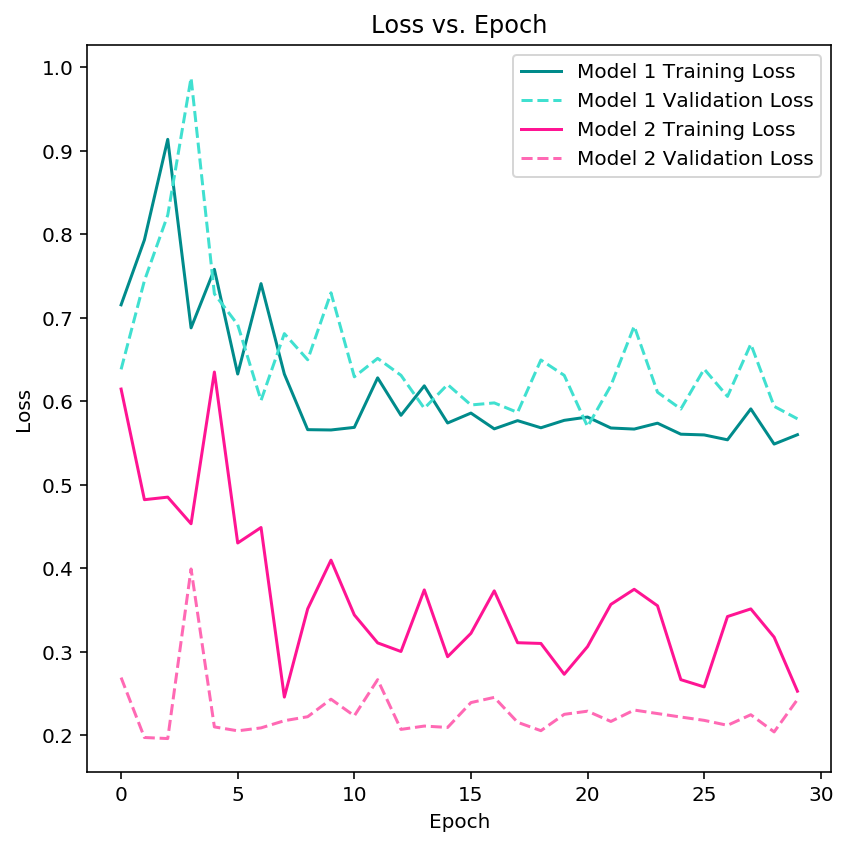

In [21]:
'''
Plotting Loss vs. Epoch
'''
plt.figure(figsize = (6, 6))
plt.title('Loss vs. Epoch')
plt.plot(range(30), train_losses1, label='Model 1 Training Loss', color=palette[0])
plt.plot(range(30), val_losses1, label='Model 1 Validation Loss', color=palette[1], linestyle='--')
plt.plot(range(30), train_losses2, label='Model 2 Training Loss', color=palette[2])
plt.plot(range(30), val_losses2, label='Model 2 Validation Loss', color=palette[3], linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

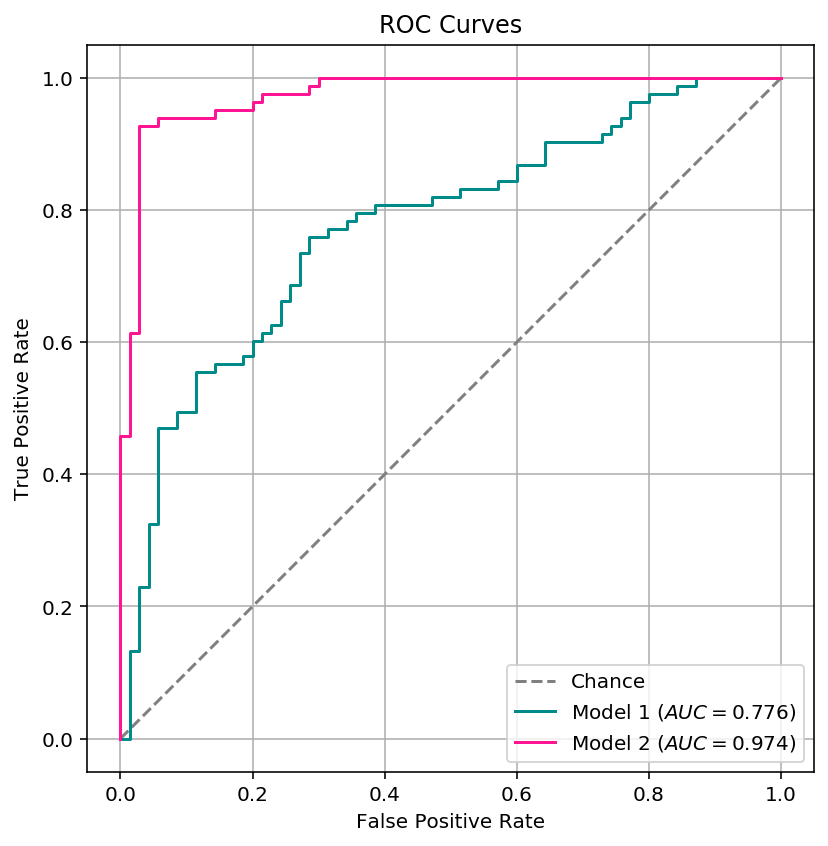

In [26]:
'''
Plotting ROC Curves for Performance on Validation Set
'''
# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')

# Plot ROC for each model
plot_roc(y1, scores1, legend='Model 1', color=palette[0])
plot_roc(y2, scores2, legend='Model 2', color=palette[2])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.tight_layout()

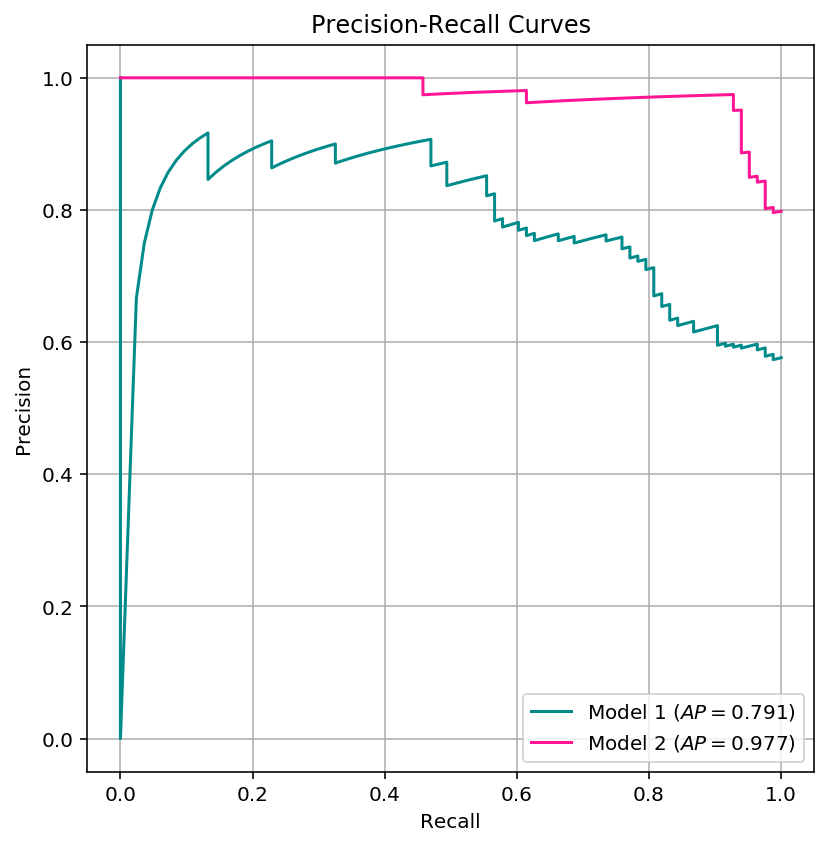

In [27]:
'''
Plotting PRC Curves for Performance on Validation Set
'''
# Compute and plot the PRC curves
plt.figure(figsize = (6, 6))
plt.title('Precision-Recall Curves')

# Plot ROC for each model
plot_prc(y1, scores1, legend='Model 1', color=palette[0])
plot_prc(y2, scores2, legend='Model 2', color=palette[2])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()

## 6. Appendix

Printing confusion matrices for both models and sample images.

In [15]:
'''
Confusion Matrix for Model 1
'''
pd.DataFrame(confusion_matrix(y1, list(map(lambda x: round(x, 0), scores1))))

,0,1
0,48,22
1,19,64


In [16]:
'''
Confusion Matrix for Model 2
'''
pd.DataFrame(confusion_matrix(y2, list(map(lambda x: round(x, 0), scores2))))

,0,1
0,68,2
1,6,77


In [17]:
def imshow(inp, title=None):
    """Function to display tensor images"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    #plt.pause(0.001)  # pause a bit so that plots are updated

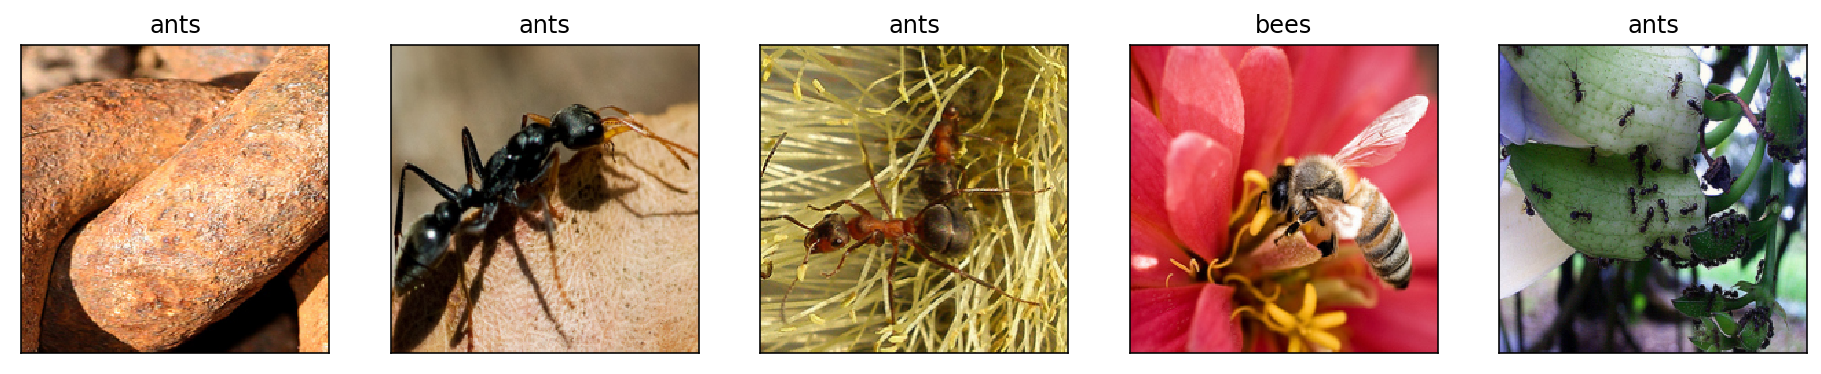

In [32]:
'''
Sample images with actual labels
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
#plt.suptitle('Sample images with actual labels')

for i in range(5):
    inputs, classes = next(iter(dataloaders['train']))
    plt.subplot(1, 5, i + 1)
    imshow(inputs[0], class_names[classes[0]])

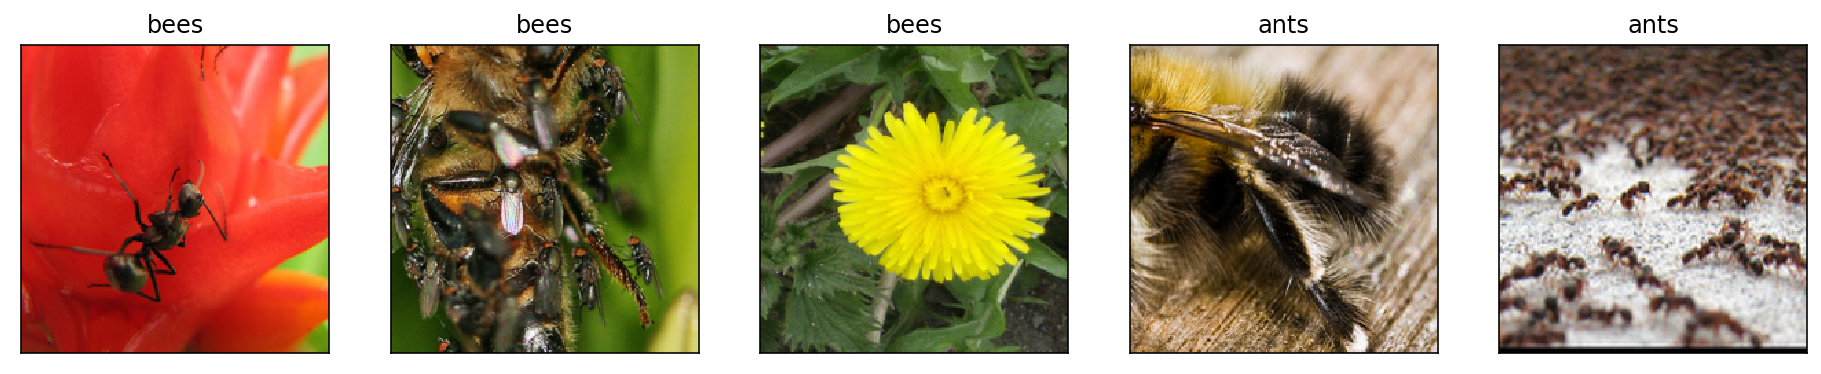

In [19]:
'''
Sample images with predictions with Model 1
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
#plt.suptitle('Sample images with predicted labels')

for i in range(5):
    inputs, classes = next(iter(dataloaders['train']))
    outputs  = model1(inputs)
    _, preds = torch.max(outputs, 1)
    plt.subplot(1, 5, i + 1)
    imshow(inputs[0], class_names[preds[0]])

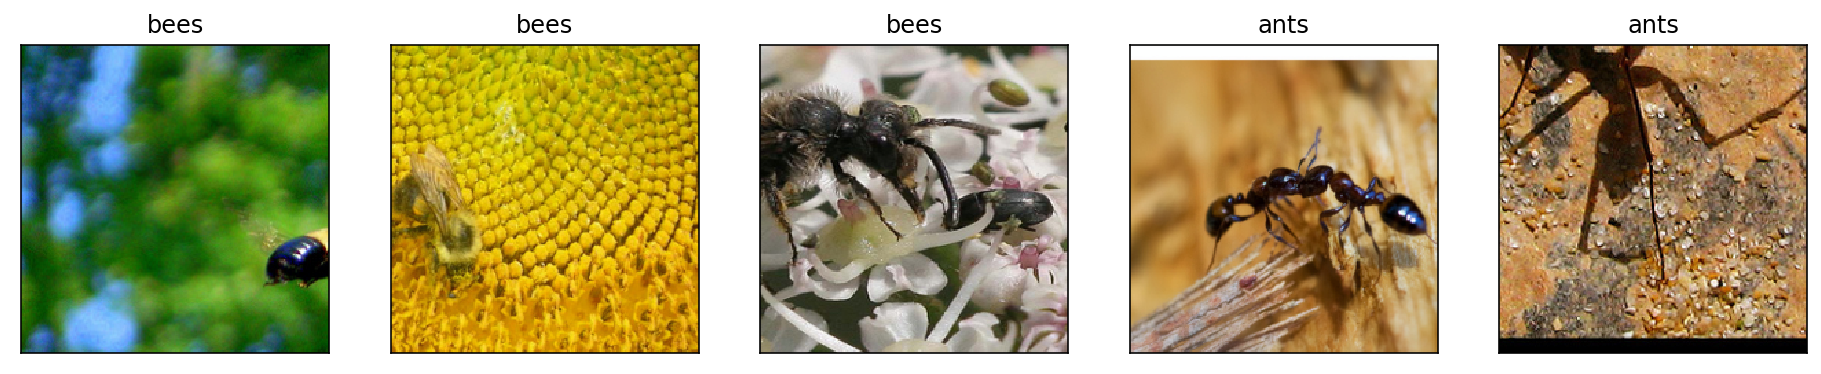

In [20]:
'''
Sample images with predictions with Model 2
'''
rcParams['figure.figsize'] = 16, 3
plt.figure()
#plt.suptitle('Sample images with predicted labels')

for i in range(5):
    inputs, classes = next(iter(dataloaders['train']))
    outputs  = model2(inputs)
    _, preds = torch.max(outputs, 1)
    plt.subplot(1, 5, i + 1)
    imshow(inputs[0], class_names[preds[0]])